# Setup

In [1]:
# library to check function types of imported modules
from typeguard import install_import_hook

# custom functions for plotting, etc.
with install_import_hook('custom_ml_plots'):
    import custom_ml_plots as cmp
with install_import_hook('custom_dataset_tools'):
    import custom_dataset_tools as cdt
with install_import_hook('basic_ml_operations'):
    import basic_ml_operations as bmo
with install_import_hook('ml_data_objects'):
    import ml_data_objects as mdo

# data import
import pyreadr

# data storage libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr


# Scaling
from sklearn.preprocessing import StandardScaler

# k-fold cross-validation
from sklearn.model_selection import KFold

# global parameters
RANDOM_STATE = 42
TEST_SET_PORTION = 0.15
CV_SET_PORTION = 0.15
TOP_LINE_THRESH = 0.8

## Import Data

In [2]:
# import dataset
eyt1 = pyreadr.read_r('./data/eyt1.RData')

# extract training example labels
y = eyt1['Pheno_Disc_Env1']

y.head()

,GID,Env,DTHD,DTMT,GY,Height
0,GID6569128,Bed5IR,1.0,1.0,6.119272,0.0
1,GID6688880,Bed5IR,2.0,2.0,5.855879,0.0
2,GID6688916,Bed5IR,2.0,2.0,6.434748,0.0
3,GID6688933,Bed5IR,2.0,2.0,6.350670,0.0
4,GID6688934,Bed5IR,1.0,2.0,6.523289,0.0


In [3]:
y = y[['GY']].set_index(y['GID'])

# sort by index
y = y.sort_index()

# check missing values
cdt.assert_no_bad_values(y)

# each seed was planted in 4 different environments, but we don't care about environmental differences
# so we take the average of every group of four rows to reduce the dataset to 1/4 its original size
y = cdt.avg_rows(y, 4)

y.head()

,GY
GID,
GID6569128,5.160521
GID6688880,5.988963
GID6688916,5.781745
GID6688933,5.434369
GID6688934,5.551610


In [4]:
# extract feature matrix
X = eyt1['Geno_Env1']

X.head()

,GID6569128,GID6688880,GID6688916,GID6688933,GID6688934,GID6688949,GID6689407,GID6689482,GID6689550,GID6738288,...,GID6939899,GID6939900,GID6939902,GID6939903,GID6939904,GID6939917,GID6939919,GID6939938,GID6939941,GID6939945
GID6569128,0.788801,-0.006443,0.025987,-0.138795,-0.157880,0.096213,-0.110899,0.013069,-0.040445,0.007931,...,0.125612,0.133808,0.137456,0.127674,0.130468,0.004096,0.091188,0.074009,0.032992,0.199459
GID6688880,-0.006443,0.980542,0.064585,-0.168773,-0.081006,0.078890,-0.201346,0.124671,0.253505,0.013636,...,0.072171,0.061650,0.057898,0.079085,0.061086,0.104630,0.113878,0.108757,0.154718,0.004447
GID6688916,0.025987,0.064585,1.170073,-0.021636,-0.031717,0.101532,-0.196780,0.041900,-0.013459,0.126464,...,0.428609,0.423184,0.427788,0.408326,0.426844,0.006038,0.209395,0.240468,0.255337,0.163524
GID6688933,-0.138795,-0.168773,-0.021636,0.879004,0.443678,-0.080560,0.402479,-0.218803,-0.102718,-0.002303,...,-0.079312,-0.087824,-0.089912,-0.067028,-0.084206,-0.140529,-0.088961,-0.096740,-0.159136,-0.108800
GID6688934,-0.157880,-0.081006,-0.031717,0.443678,0.996666,-0.140766,0.395843,-0.310471,-0.138902,0.088169,...,-0.016690,-0.017375,-0.026372,-0.014478,-0.016350,-0.098509,-0.052304,-0.012778,-0.100318,-0.154557


In [5]:
# scale feature matrix
X_scaler = StandardScaler()
X_sc = pd.DataFrame(X_scaler.fit_transform(X), index=X.index, columns=X.columns)

y_scaler = StandardScaler()
y_sc = pd.DataFrame(y_scaler.fit_transform(y), index=y.index, columns=y.columns)

y_sc.head()

,GY
GID,
GID6569128,-1.069311
GID6688880,1.412830
GID6688916,0.791971
GID6688933,-0.248819
GID6688934,0.102451


In [6]:
def plot_decorated_grid(y_preds_grid: np.ndarray, y_test_grid: np.ndarray, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, pearson_grid: np.ndarray, plot_title: str, i: int):
    """
    Plot predictions vs actuals and colour by pearson coefficient and add best fit
    Created: 2024/11/30
    """
    # create plot of predictions vs actuals
    fig, axs = cmp.plot_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, f"{plot_title} | Inner Fold {i}")

    # colour by pearson coefficient and add best fit and title
    cmp.color_spectrum(fig, axs, pearson_grid, label="Pearson Coefficient")
    cmp.add_best_fit(axs)

In [ ]:
def inner_CV_R(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, plot_title: str = "", **kwargs):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # arrays to store best parameters for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        """print(f'Fold {i}')"""
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        """
        print('Training data:')
        print(f'X: {X_train}')
        print(f'y: {y_train}')
        """
        # train model grid
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # use trained models to predict test set
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # create grid of actuals to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # evaluate predictions by comparing to actuals, calculating pearson coefficient
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        """        
        print(f'Model grid:')
        # print each model's tree count and depth
        for row in range(model_grid.shape[0]):
            for col in range(model_grid.shape[1]):
                model = model_grid[row, col]
                print(f'Model at row {row}, col {col}:')
                print(f'n_estimators: {model.get_params()["n_estimators"]}, max_depth: {model.get_params()["max_depth"]}')
        print(f'Actuals:\n {y_test_grid}')
        print(f'Preds:\n {y_preds_grid}')
        """

        # find index of best pearson coefficient in the 2d array of pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # store best parameters for this fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]

        plot_decorated_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, plot_title, i)        

    # calculate average best parameters over all folds
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    return avg_best_param1, avg_best_param2

        

In [8]:
def outer_CV_R(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, **kwargs) -> pd.DataFrame:
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # find average best values using inner fold CV
        best_param1, best_param2 = inner_CV_R(n_inner_splits, X_train, y_train, axis1_params, axis2_params, train_model_callback, kfold_random_state, plot_title=f"Outer Fold {i}", **kwargs)

        # train model with all training data of outer fold using average best parameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # use trained model to predict test set
        y_pred = pd.DataFrame(super_model.predict(X_test), index=y_test.index, columns=y_test.columns)

        # calculate pearson coefficient
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # classify predictions and actuals as top or not top
        y_pred_top = cdt.classify_top(y_pred, TOP_LINE_THRESH)
        y_test_top = cdt.classify_top(y_test, TOP_LINE_THRESH)

        # calculate classification metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)

        # combine pearson and classification metrics into one dataframe side by side, then add them to kfold_metrics
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)        
    
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics

# Model R

## Support Vector Machine

"""
# Real values
x_params_SVM = mdo.AxisParams('gamma', bmo.power_list(2, -13, -5))
y_params_SVM = mdo.AxisParams('C', bmo.power_list(2, -3, 5))
"""
# Dummy values for quick training tests
x_params_SVM = mdo.AxisParams('gamma', bmo.power_list(2, -8, -7))
y_params_SVM = mdo.AxisParams('C', bmo.power_list(2, 0, 1))
metrics_SVM = outer_CV_R(10, 5, X_sc, y_sc, x_params_SVM, y_params_SVM, bmo.train_SVR, kfold_random_state=RANDOM_STATE)

# display metrics
display(metrics_SVM)

# Print average of each metric
display(metrics_SVM.mean())

## XGBoost

Fold 0
Training data:
X:             GID6569128  GID6688880  GID6688916  GID6688933  GID6688934  \
GID6688933   -1.548635   -1.842393   -0.423965    6.395732    3.101107   
GID6688934   -1.704880   -0.938783   -0.485334    3.361453    6.558471   
GID6689550   -0.743451    2.505211   -0.374189   -0.447006   -0.541270   
GID6861813    0.353392   -1.197262   -0.320695    0.838101    0.640149   
GID6861897    1.654755   -1.168662   -0.988551   -0.564325   -0.577265   
...                ...         ...         ...         ...         ...   
GID6939838    0.741413    0.484468    2.331950   -0.322871    0.254974   
GID6939840    0.554587    0.700267    2.215318   -0.336884    0.296721   
GID6939904    0.655801    0.524144    2.306180   -0.317972    0.224940   
GID6939938    0.193579    1.014948    1.171608   -0.405333    0.247277   
GID6939941   -0.142225    1.488148    1.262120   -0.840242   -0.300039   

            GID6688949  GID6689407  GID6689482  GID6689550  GID6738288  ...  \
GID6688

C:\Users\caoca\AppData\Local\Temp\ipykernel_7284\3558762038.py:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)


Fold 0
Training data:
X:             GID6569128  GID6688880  GID6688916  GID6688933  GID6688934  \
GID6688916   -0.199577    0.560172    6.830623    0.118148    0.128864   
GID6689407   -1.320251   -2.177752   -1.490164    3.074290    2.802034   
GID6738288   -0.347397    0.035613    0.477603    0.252901    0.878409   
GID6861833   -0.669607    1.643512   -0.431334   -0.716990   -1.068597   
GID6862002   -0.252124    0.080386    2.820133    0.056824    0.306255   
...                ...         ...         ...         ...         ...   
GID6939845    0.129702    0.935369    0.519680   -0.902478   -1.231810   
GID6939864   -0.172048    0.303576    1.693412   -0.585528    0.003964   
GID6939917   -0.378798    0.972458   -0.255500   -0.710555   -0.288730   
GID6939919    0.334219    1.067666    0.982447   -0.351119    0.000153   
GID6939945    1.220629   -0.058990    0.703207   -0.489397   -0.639151   

            GID6688949  GID6689407  GID6689482  GID6689550  GID6738288  ...  \
GID6688

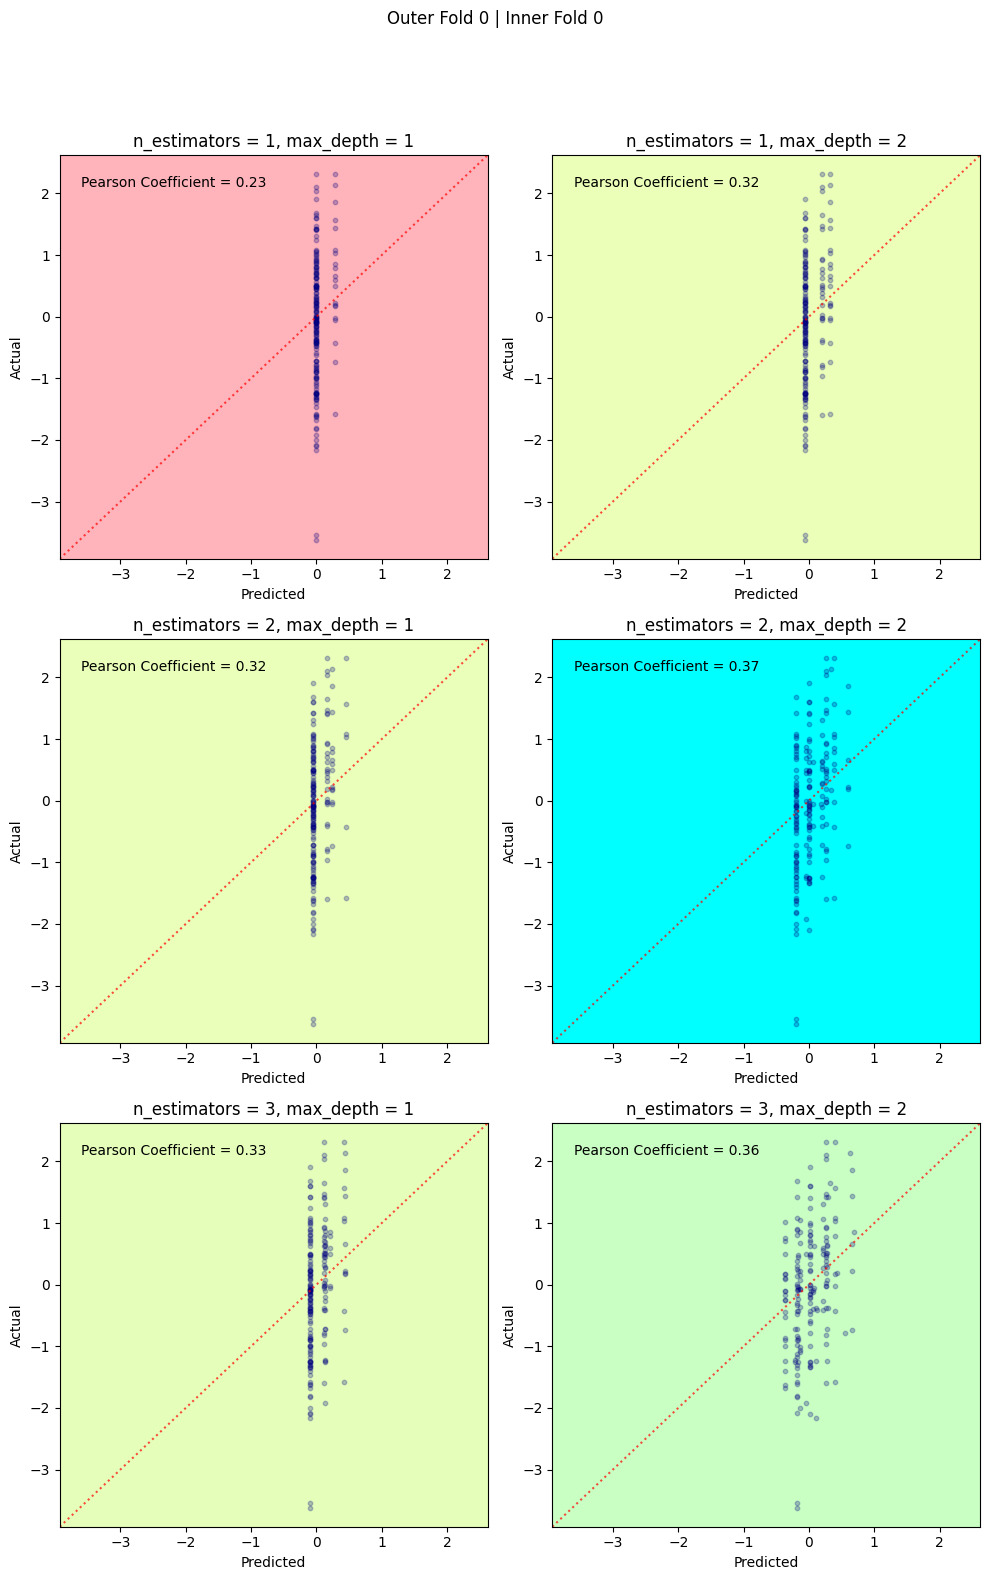

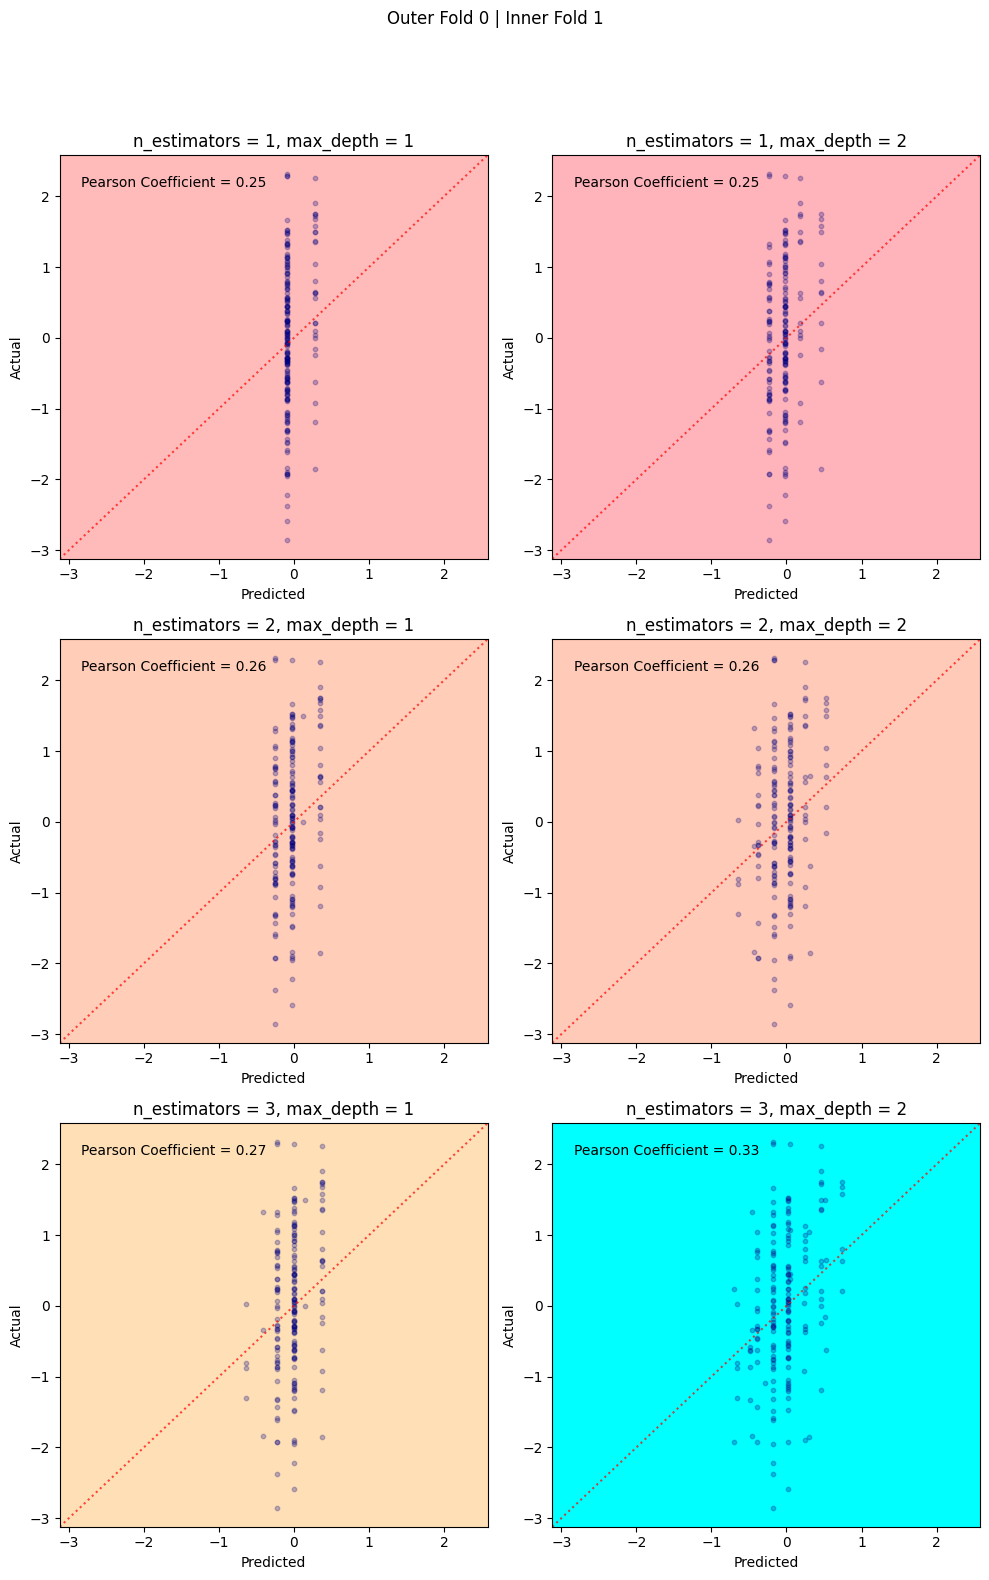

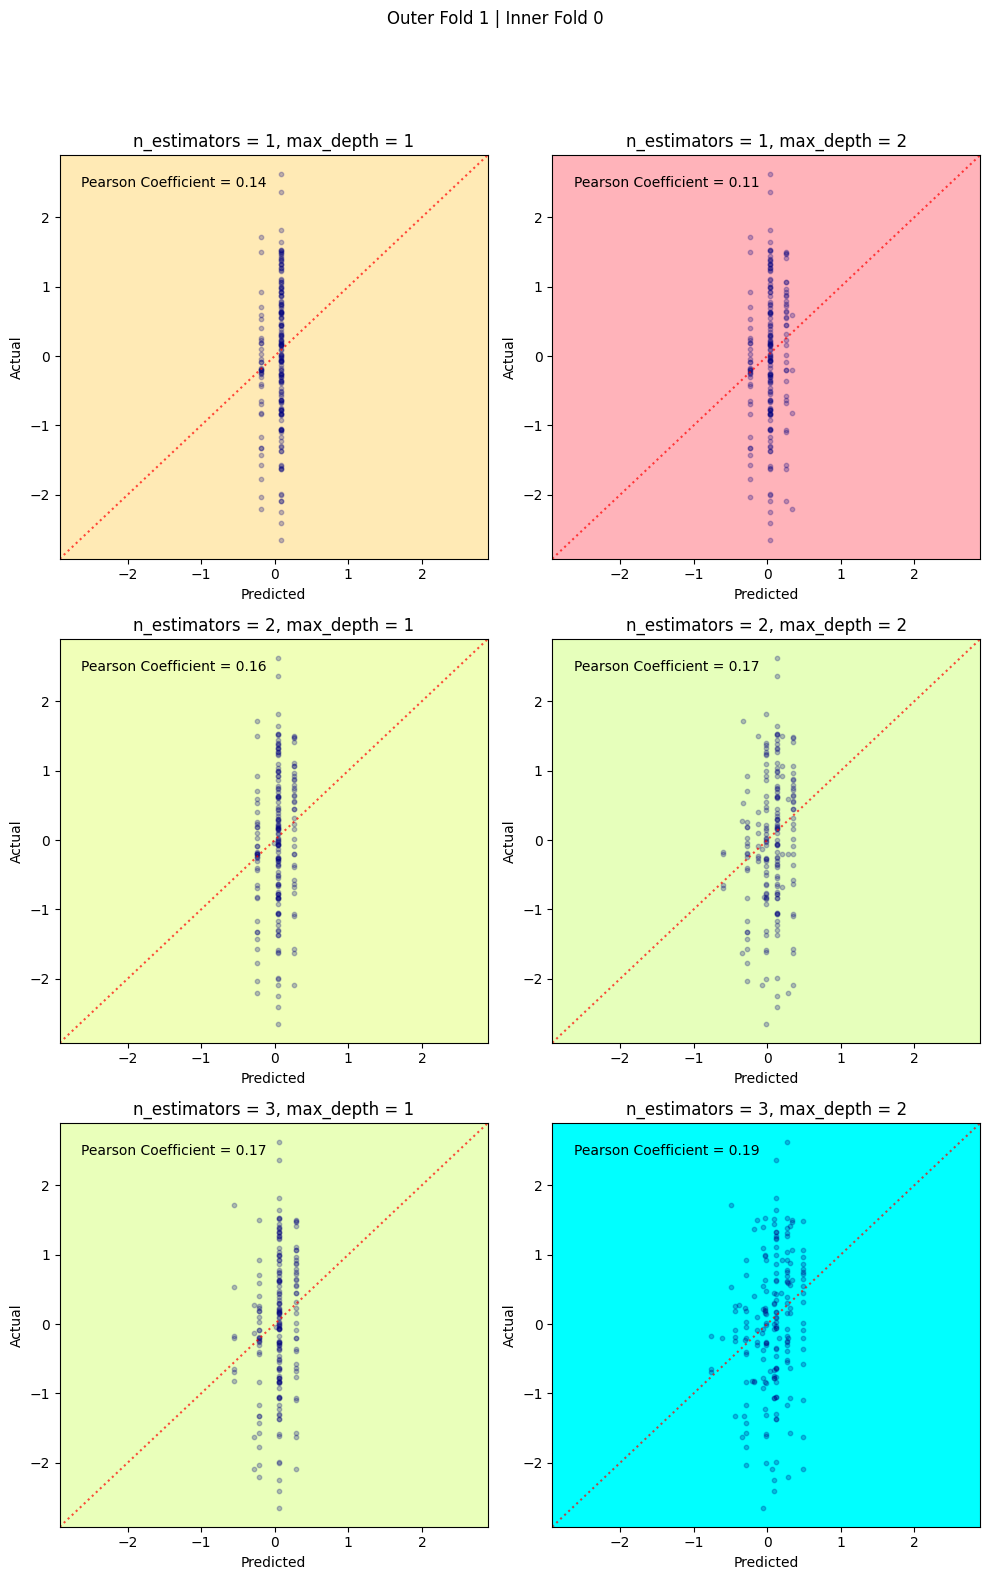

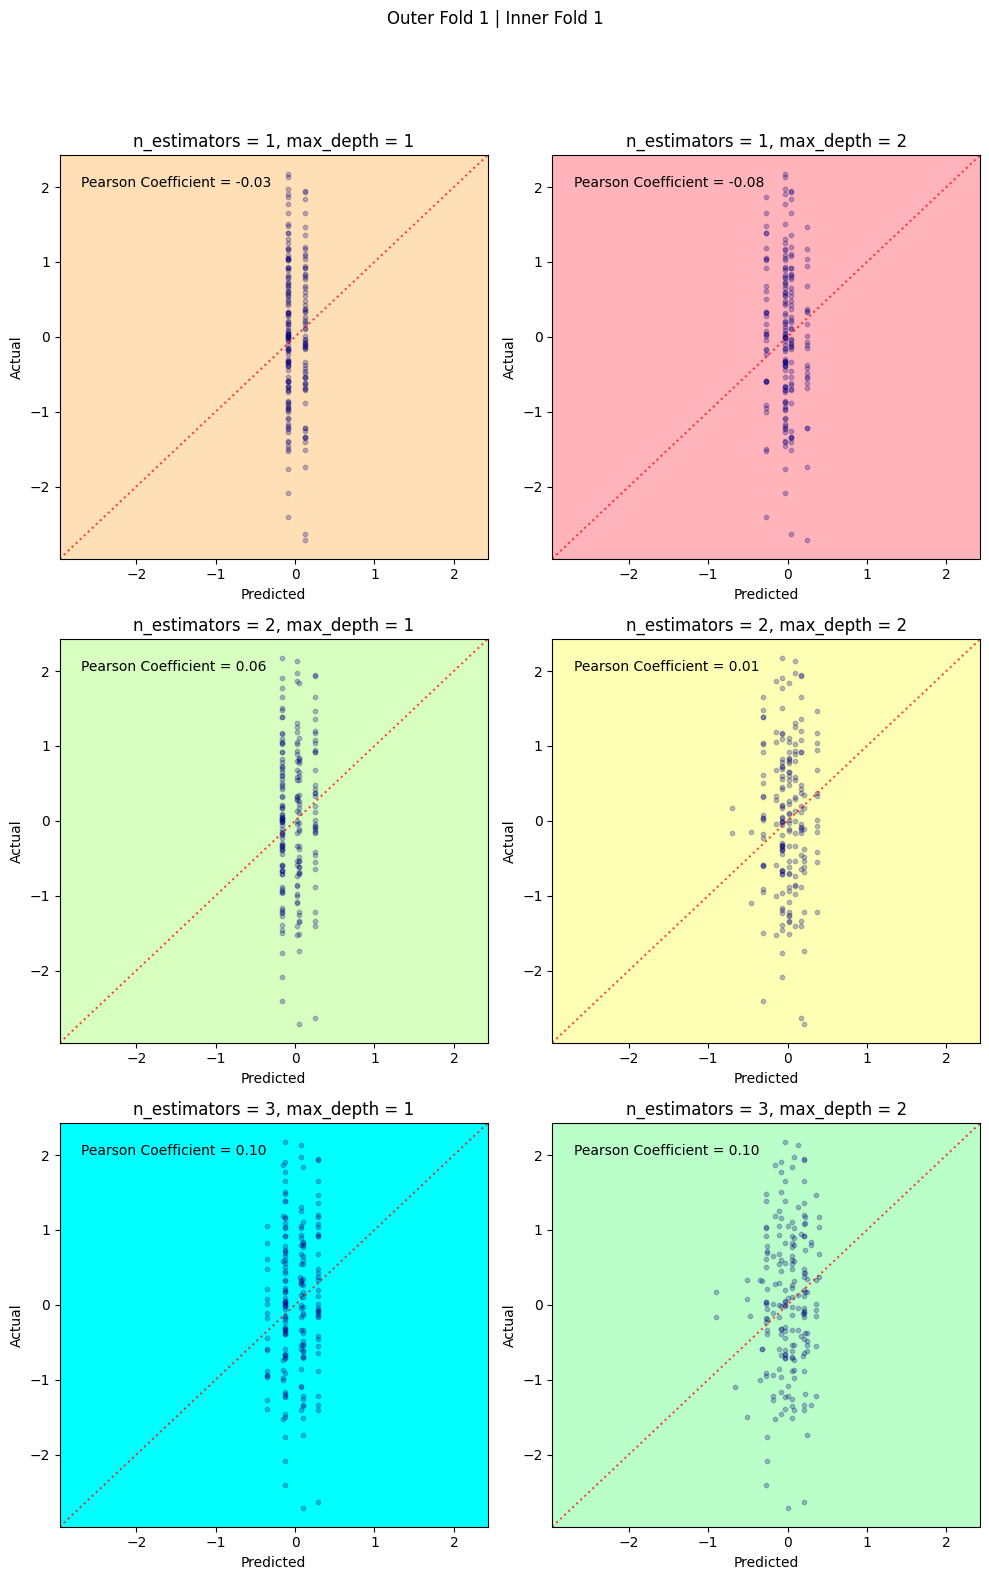

In [9]:
# test values
x_params_XGB = mdo.AxisParams('n_estimators', [1, 2, 3])
y_params_XGB = mdo.AxisParams('max_depth', [1, 2])

"""# dummy values
x_params_XGB = mdo.AxisParams('n_estimators', [50, 100, 200, 300])
y_params_XGB = mdo.AxisParams('max_depth', [4, 8])"""
"""# Define parameter ranges for XGBoost
x_params_XGB = mdo.AxisParams('n_estimators', [50, 100, 200, 300, 400, 500, 600, 700, 800])
y_params_XGB = mdo.AxisParams('max_depth', [4, 8])
"""
# Perform grid search with XGBoost models
metrics_XGB = outer_CV_R(2, 2, X_sc, y_sc, x_params_XGB, y_params_XGB, bmo.train_XGB_reg, kfold_random_state=RANDOM_STATE, random_state=RANDOM_STATE)


In [10]:
# display metrics
display(metrics_XGB)

,Pearson,F1 Score,Sensitivity,Specificity,Kappa
0,0.255133,0.276730,0.285714,0.803922,0.087510
1,0.305257,0.336957,0.402597,0.751634,0.134608


In [11]:
# Print average of each metric
display(metrics_XGB.mean())

Pearson        0.280195
F1 Score       0.306843
Sensitivity    0.344156
Specificity    0.777778
Kappa          0.111059
dtype: float64

# Model B

In [12]:
# Replace range of labels with binary variable representing whether the gene line is top or not
y_sc_top = cdt.classify_top(y_sc, TOP_LINE_THRESH)
display(y_sc_top)

,GY
GID,
GID6569128,False
GID6688880,True
GID6688916,False
GID6688933,False
GID6688934,False
...,...
GID6939917,False
GID6939919,False
GID6939938,False


In [13]:
def inner_CV_B(n_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, plot_title: str = "", **kwargs):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=kfold_random_state)

    # arrays to store best parameters for each fold
    best_params = pd.DataFrame(columns=['param1', 'param2'], index=range(n_splits))
    best_thresholds = pd.DataFrame(columns=['threshold'], index=range(n_splits))

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # train model grid
        model_grid = bmo.train_model_grid(X_train, y_train, axis1_params, axis2_params, train_model_callback, **kwargs)

        # use trained models to predict test set
        y_preds_grid = bmo.grid_predict(X_test, model_grid)

        # create grid of actuals to compare against predictions
        y_test_grid = cdt.np_array_of_dfs(y_test, y_preds_grid.shape)

        # evaluate predictions by comparing to actuals, calculating pearson coefficient
        pearson_grid = bmo.calculate_pearson_coefficients(y_preds_grid, y_test_grid)

        # find index of best pearson coefficient in the 2d array of pearson coefficients
        best_row, best_col = np.unravel_index(np.argmax(pearson_grid), pearson_grid.shape)
        
        # store best parameters for this fold
        best_params.loc[i] = [axis1_params.values[best_row], axis2_params.values[best_col]]

        # find classification threshold that yields lowest squared difference between sensitivity and specificity using this optimal model
        best_model_y_preds = y_preds_grid[best_row, best_col]
        best_thresholds.iloc[i, 0] = bmo.find_optimal_threshold(y_test, best_model_y_preds)

        plot_decorated_grid(y_preds_grid, y_test_grid, axis1_params, axis2_params, pearson_grid, plot_title, i)        

    # calculate average best parameters over all folds
    avg_best_param1 = best_params['param1'].mean()
    avg_best_param2 = best_params['param2'].mean()

    # calculate average best threshold over all folds
    best_threshold = best_thresholds['threshold'].mean()

    return avg_best_param1, avg_best_param2, best_threshold

        

In [14]:
def outer_CV_B(n_outer_splits: int, n_inner_splits: int, X : pd.DataFrame, y : pd.DataFrame, axis1_params: mdo.AxisParams, axis2_params: mdo.AxisParams, train_model_callback, kfold_random_state: int, **kwargs) -> pd.DataFrame:
    
    kfold = KFold(n_splits=n_outer_splits, shuffle=True, random_state=kfold_random_state)

    kfold_metrics = pd.DataFrame(columns=['Pearson', 'F1 Score', 'Sensitivity', 'Specificity', 'Kappa'])

    # Iterate through each train-test split
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # find average best values using inner fold CV
        best_param1, best_param2, best_threshold = inner_CV_R(n_inner_splits, X_train, y_train, axis1_params, axis2_params, train_model_callback, kfold_random_state, plot_title=f"Outer Fold {i}", **kwargs)

        # train model with all training data of outer fold using average best parameters
        super_model = train_model_callback(X_train, np.ravel(y_train), **dict(zip([axis1_params.name, axis2_params.name], [best_param1, best_param2])), **kwargs)

        # use trained model to predict test set
        y_pred = pd.DataFrame(super_model.predict(X_test), index=y_test.index, columns=y_test.columns)

        # calculate pearson coefficient
        pearson, _ = pearsonr(np.ravel(y_pred), np.ravel(y_test))

        # classify predictions and actuals as top or not top
        y_pred_top = cdt.classify_top(y_pred, best_threshold)
        y_test_top = cdt.classify_top(y_test, best_threshold)

        # calculate classification metrics
        classification_metrics = cdt.classification_metrics(y_pred_top, y_test_top)

        # combine pearson and classification metrics into one dataframe side by side, then add them to kfold_metrics
        pearson_df = pd.DataFrame([pearson], columns=['Pearson'])
        metrics_row = pd.concat([pearson_df, classification_metrics], axis=1)
        kfold_metrics = pd.concat([kfold_metrics, metrics_row], axis=0)        
    
    kfold_metrics.index = range(n_outer_splits)
    return kfold_metrics